In [1]:
%pip install --upgrade pip
%pip install scipy matplotlib scikit-learn==0.23 requests pandas numpy

Requirement already up-to-date: pip in ./venv/lib/python3.6/site-packages (20.2.4)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import scipy
import matplotlib.pyplot as plt
import requests
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import datasets

# Dimensionality Reduction with Principle Component Analysis

## 1 - Introduction
The purpose of this notebook is to summarize the applications and theory of principal component analysis (PCA), an algorithm for linear dimensionality reduction \[1,2,3].  High dimesional data often contains more information than we need \[3].  High dimensional data can often be thought of as a combination of it's lower dimensions \[3].  The main goal of dimensionality reduction is to gain a lossless lower dimension representation of data \[3].  Dimensionality reduction is massively useful, whether in the form of lossless compression algorithms, or as a tool for classifying datasets \[3]. In preparation for this notebook, it may be helpful to review Sections 3.8, 4.2 and 6.4 as these topics are heavily used in the formulation of PCA \[3]. 

### Example 1.0.1 Visualizing PCA as Projection of Data in $\mathbb{R}^2$ to $\mathbb{R}^1$
Projections are a useful tool in compressions, as it can be possible to represent a dataset with less dimensions but high similarity. This example shows a 1 dimensional representation of 2 dimensional data.  It is important to note that this is not the optimal compression for the dataset, as I simply use the x coordinates of a set of randomly generated data.  Finding the optimal coordinates will be explained in the following sections.

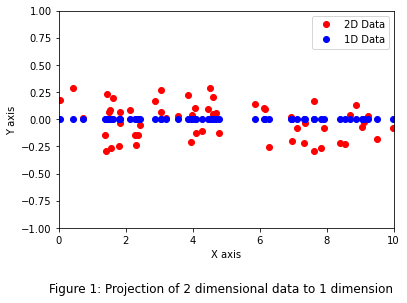

In [3]:
np.random.seed(0)
num_data = 100
y_vals = np.random.uniform(-0.3, 0.3, num_data) # generate random y coordinates
x_vals = np.random.uniform(-10, 10, num_data) # generate random x coordinates
plt.figure()
plt.plot(x_vals, y_vals, 'ro', label="2D Data") # plot 2D data
plt.plot(x_vals, np.zeros(num_data), 'bo', label="1D Data") # plot 1D data

plt.axis([0,10,-1,1])
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.figtext(0.5, -0.1, "Figure 1: Projection of 2 dimensional data to 1 dimension", wrap=True, horizontalalignment='center', fontsize=12)
plt.legend()

It is easy to see that the 1D data can closely represent the 2D data. The loss in the lower state representation is visualized as the y distance from a blue point to its red point vertically above or below itself.

## 1.1 The Iris Dataset
We will be using the iris dataset for examples in this notebook.  The iris dataset contains data about different types of flowers characterized by their sepal length, sepal width, petal length and petal width.  Iris is well known as an easy classification problem and will be useful in furthering our understanding of PCA applied to data. We start by loading the data from the ```sklearn``` python package into two ```pandas``` dataframes:

1. ```iris_fulldf``` : the dataframe including the target column (the labels for classification)
2. ```iris_featuredf``` : the dataframe with no labels (we apply PCA to this dataframe as we wish to observe how the labelless data maps to 2 dimensions)

In [4]:
iris_d = sklearn.datasets.load_iris(as_frame=True)
iris_fulldf = iris_d['frame'] # full frame with features and target
iris_fulldf.rename(columns={"sepal length (cm)" : "sepal length", # remove dimensions from column titles
                            "sepal width (cm)" : "sepal width",   # to reduce confusion
                            "petal length (cm)" : "petal length",
                            "petal width (cm)" :	"petal width"}, inplace=True)
iris_featuredf = iris_fulldf.drop(columns=["target"]) # frame with features only

iris_fulldf.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0




## 2 Representing Coordinates
PCA aims to to collect the projections $\tilde{x}_n$ of data points $x_n$ \[3]. The challenge is to have our lower dimensional data $\tilde{x_n}$ as closely related to the original data, $x_n$, as possible.

Three equations are presented below:

\begin{equation}
\textbf{S} = \frac{1}{N}\sum_{n=1}^{N}x_nx_n^\top \tag{1}
\end{equation}
\begin{equation}
z_n = B^\top x_n \in \mathbb{R}^{M}  \tag{2}
\end{equation}
\begin{equation}
B := \begin{bmatrix}b1, ... ,b_M\end{bmatrix} \in \mathbb{R}^{D\times M}. \tag{3}
\end{equation}



In short, $B$ is a projection matrix, with orthonormal columns. $U \subseteq \mathbb{R}^D,\: \text{dim}(U) = M < D$ where $\exists\: \tilde{x_n} \in U$ \[3]. $U$ is the $M$ dimensional subspace onto which we project the data $\tilde{x_n}$ with coordinates $z_n$ \[3]. Lastly, $S$ represents the data covariance matrix of an independent and identically distributed (i.d.d) dataset $X = {x_1, ... , x_N}, x_n \in \mathbb{R}^D$ \[3].


## 3 - Maximum Variance Perspective
The challenge in dimensionality reduction is minimizing the loss \[3]. This can be equivalently thought of maximizing the variance in our low dimension representation \[3]. We can formulate the following for the variance of our lower dimensional data, labelling $\mu$ as the mean \[3].

\begin{equation}
\mathbb{V}_z[Z] = \mathbb{V}_x[B^\top(x - \mu)] = \mathbb{V}_x[B^\top x - B^\top\mu] = \mathbb{V}_x[B^\top x]. \tag{4}
\end{equation}

Our low dimensional data's variance thus has no dependance on $\mu$ and so we can assume our data and its low dimensional form have means of 0 \[3].

### Example 3.0.1 -- Standardizing a Dataset

Standardizing our data before applying PCA analysis is important, as many of the following analysis relies on the mean of the data equaling zero.  Standardizing the data subtracts the mean, and divides by the standard devation across each data point i.e $\sum_{n-1}^N \frac{x_n - \mu}{\sigma}$. Instead of actually applying this formula element by element to a dataset, ```sklearn``` provides the tools we need for standardization: ```StandardScaler()```.  I have wrapped the ```StandardScaler()``` a function in order to reuse later in the notebook.

In [5]:
def standardize(df):
    """
    Takes a dataframe, and gathers a standardized version of it.
    Arguments
        df : some pandas dataframe
        return : a standardized version  of the df
    """
    names = df.columns
    scaler = preprocessing.StandardScaler()
    std_df = scaler.fit_transform(df)
    std_df = pd.DataFrame(std_df, columns=names)
    return std_df

Applying ```standardize()``` to the iris dataframe containing only the features (no labels), ```iris_featuredf``` gives:

In [6]:
iris_stdz = standardize(iris_featuredf)
iris_stdz.head()

,sepal length,sepal width,petal length,petal width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


### 3.1 Getting the direction with maximal variance

\[3] uses a sequential approach in the formulation of the maximum variance approach.  First, the variance of the first coordinate in $z$, $z_1$ is maximized \[3].  
$$
\begin{equation}
V_1 := \mathbb{V}[z_1] = \frac{1}{N}\sum_{n=1}^{N}z_{1n}^2. \tag{5}
\end{equation}
$$
The first component of $z_n$ is represented as $z_{n1} = b_1^\top x_n$. $z_{n1}$ which may then be substituted into (5) to obtain
$$
\begin{equation}
V_1 = b_1^\top S b_1. \tag{6}
\end{equation}
$$
We constrain the solution space to $\|b_1^2\| = 1$ to counter act any scaling on $V_1$ by increases in $b_1$ \[3].  Thus, we can now find $b_1$ that points in the maximum variance's direction by solving a constrained optimization problem with the Lagrangian \[3].

$$
\begin{equation}
\max_{b_1} b_1^\top S b_1 \: \text{subject to} \: \|b_1\|^2 = 1. \tag{7}
\end{equation}
$$

If we apply the lagrangian and solve the optimization problem i.e. $\frac{\partial \mathcal{L}}{\partial b_1} = 0, \frac{\partial \mathcal{L}}{\partial\lambda_1} = 0$ we obtain equations (8) and (9) \[3].
$$
\begin{equation}
    Sb_1 = \lambda_1b_1, \tag{8}
\end{equation}
$$
$$
\begin{equation}
    b_1^\top b_1 = 1. \tag{9}
\end{equation}
$$
We can thus rewrite (4):
$$
\begin{equation}
    V_1 = b_1^\top Sb_1 = \lambda_1b_1^\top b_1 = \lambda_1. \tag{10}
\end{equation}
$$
In summary, the data projected onto a single dimension subspace has a variance equal to the eigenvalue associated with the basis vector $b_1$, spanning the subspace \[3].  The eigenvector associated with $\lambda_1$ is called the principal component and we can observe the prinicpal component's contribution to the original data by mapping our coordinate $z_{1n}$ back to the data space by
$$
\begin{equation}
\tilde{x_n} = b_1z_{1n} = b_1b^\top x_n \in \mathbb{R}^D. \tag{11}
\end{equation}
$$

### 3.2 Extending Maximal Variance Perspective to M Dimensions
If we know $m-1$ principal components (eigenvectors) of the data covariance matrix $S$ that are associated with $m-1$ eigenvalues and $S$ is symetric we can apply spectral theorem to construct an orthonormal eigenbasis the $(m-1)$ dimensional subspace of $\mathbb{R}^D$ \[3]. We can construct a relation defining a new data matrix $\hat{X}$ by subtracting the principal components' contributions $b_1 . . . b_{m-1}$ from the data $X$ \[3].
$$
\begin{equation}
    \hat{X} := X - \sum_{i=1}^{m-1}b_ib_i^\top X = X - B_{m-1}X \tag{12}
\end{equation}
$$
$X \in \mathbb{R}^{D\times N}$ contains all individual data points $\begin{bmatrix}x_1, ...,x_N\end{bmatrix}$ as column vectors, while $B_{m-1} := \sum_{i=1}^{m-1}b_ib_\top$ is a projection matrix projecting onto the subspace spanning $\{b_1, ..., b_{m-1}\}$ \[3].

If we maximize the variance, we can find the $m$th principal component
$$
\begin{equation}
    V_m = \mathbb{V}[z_m] = \frac{1}{N}\sum_{n=1}^{N}z_{mn}^2 = \frac{1}{N}\sum_{n=1}^{N}(b_m^\top \hat{x_n})^2 = b_m^\top \hat{S}b_m, \tag{13}
\end{equation}
$$
constrained by $\|b_m\|^2 = 1$.

By following a procedure similar to that of (10), if can be shown that 
$$
\begin{equation}
V_m = b_m^\top Sb_m = \lambda_mb_m^\top b_m = \lambda_m. \tag{14}
\end{equation}
$$

In conclusion we can find the M-dimensional subspace of $\mathbb{R}^D$ while retaining as much information as possible by choosing columns of matrix $B$ as $M$ eigenvectors of data covariance matric $S$ associated with $M$ largest eigenvalues \[3].

Thus the maximum amount of variance that PCA can collect given the M principal components of the data is 
$$
\begin{equation}
V_M = \sum_{m=1}^{M}\lambda_m. \tag{15}
\end{equation}
$$
The compression loss for PCA is defined as 
$$
\begin{equation}
J_M := \sum_{j=M+1}^{D}\lambda_j = V_D - V_M. \tag{16}
\end{equation}
$$



### Example 3.2.1 -- How Many Principal Components Should I Choose?

In order to minimize loss in your data, you can inspect the maximum variance that PCA can collect against the number of eigenvalues -- (15) defines this relation.

1. First, we obtain the covariance matrix $S$ into variable ```iris_cov```.
2. Second, we collect the eigenvalues ```np.linalg.eigvals()```.
3. We obtain the sum of the eigenvalues for visualization of the variance by applying ```np.cumsum()```.

Text(0.5, -0.1, 'Figure 3: Cumulative variance captured by the number of eigenvalues.')

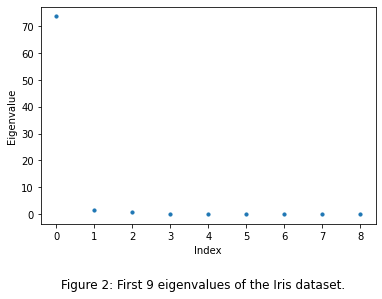

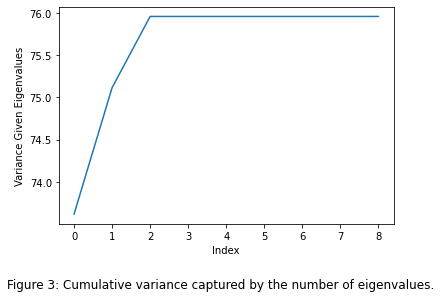

In [8]:
iris_cov = np.cov(iris_stdz) # first we obtain the covariance matrix

iris_eigs = np.linalg.eigvals(iris_cov) # then we compute the eigenvalues
iris_eigs[::-1].sort() # sort into descending order
iris_eigs = iris_eigs[1:10]
iris_variance = np.cumsum(iris_eigs) # get the summed variance along the same axis as the eigenvalues (only the real components)
indices = [i for i in range(len(iris_eigs))]

plt.figure()
plt.scatter(indices, iris_eigs, s=10)
plt.xlabel("Index")
plt.ylabel("Eigenvalue")
plt.figtext(0.5, -0.1, "Figure 2: First 9 eigenvalues of the Iris dataset.", wrap=True, horizontalalignment='center', fontsize=12)

plt.figure()
plt.plot(iris_variance)
plt.xlabel("Index")
plt.ylabel("Variance Given Eigenvalues")
plt.figtext(0.5, -0.1, "Figure 3: Cumulative variance captured by the number of eigenvalues.", wrap=True, 
            horizontalalignment='center', fontsize=12)

The above plots show how easily the iris dataset is classifed.  Maximum variance is achieved with the second principal component.  For visualization purposes, we will be using two principal components to cluster the data in a $\mathbb{R}^2$ subspace.

## 4 The Projection Perspective

PCA may also be derived according to minimal average reconstruction error \[3].  This section intuitively derives PCA by minimizing the size of the difference vectors between data points $x_n$ and $\tilde{x_n}$ \[3].  

First, \[3] assumes an ordered orthonormal basis (ONB) $B = (b_1,...,b_D) $ of $\mathbb{R}^D$, a basis can be expressed as a linear combination of the basis vectors, for any $x \in \mathbb{R}^D$ given coordinates $\zeta_d \in \mathbb{R}^D$

$$
\begin{equation}
x = \sum_{d=1}^{D}\zeta_db_d = \sum_{m=1}^M\zeta_mb_m + \sum_{j=M+1}^D\zeta_jb_j. \tag{17}
\end{equation}
$$

We wish to find the reduced dimension vectors $\tilde{x_n} \in \mathbb{R}^D$, with $\dim{(U)} = M$. We express this mathemically in (18), below \[3].

$$
\begin{equation}
\tilde{x_n} = \sum_{m=1}^{M} z_mb_m \in U \subseteq \mathbb{R}^D. \tag{18}
\end{equation}
$$

(18) ensures that we will find data as similar to $x_n$ as possible \[3]. We will minimize the Euclidean distance $\|x-\tilde{x}\|$ in order to find $\tilde{x_n}$ that is closely related to $x$ \[3].  We assume that the dataset $\mathcal{X} = {x_1, ... , x_N}, x_n \in \mathbb{R}^D$ is centered at $0$.  We can denote the projected data points as
$$
\begin{equation}
\tilde{x_n} := \sum_{m=1}^{M}z_{mn}b_m = Bz_n \in \mathbb{R^D}. \tag{19}
\end{equation}
$$

We will use the Euclidean norm (i.e. the squared distance) to minimize the distance between $x$ and $\tilde{x_n}$, and as such we define the reconstruction error from \[3] as

$$
\begin{equation}
J_M := \frac{1}{N} \sum_{n=1}^N \|x_n - \tilde{x_n}\|^2. \tag{20}
\end{equation}
$$

### Example 4.0.1 Visualization of the Minimum Euclidean Distance

I find the projection perspective a more intuitive approach to explaining PCA than the maximum variance perspective.  We will use the following example for understanding the projection perspective:

Assume that we are obtaining an $x = \mathbb{R}^1$ representation of data in $w = \mathbb{R}^2$.  We will use the x-axis for the single dimension $x$, where the the data space $w$ is spanned by vectors $x$ and $y$.  We will generate a single point in $w$, and display a number of distance vectors between the data points in $w$ and their possible optimal coordinates in $x$.

Observe the distances over the potential optimal projection 1...10: 

	[1] euclidean distance = 3.16 : coordinate [1 0]
	[2] euclidean distance = 2.24 : coordinate [2 0]
	[3] euclidean distance = 1.41 : coordinate [3 0]
	[4] euclidean distance = 1.0 : coordinate [4 0]
	[5] euclidean distance = 1.41 : coordinate [5 0]
	[6] euclidean distance = 2.24 : coordinate [6 0]
	[7] euclidean distance = 3.16 : coordinate [7 0]
	[8] euclidean distance = 4.12 : coordinate [8 0]
	[9] euclidean distance = 5.1 : coordinate [9 0]
	[10] euclidean distance = 6.08 : coordinate [10  0]

Observe the minimum distance is 1.0, corresponding to coordinate [4 0].


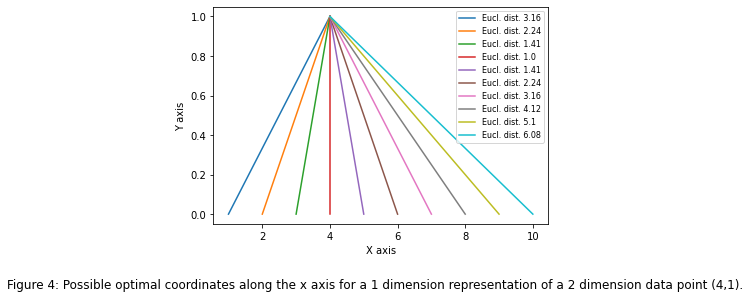

In [7]:
w_n = np.array([4,1]) # use the point x=4, y=1 as a sample from our data in w

projections = [1,2,3,4,5,6,7,8,9,10] # values along x=R^1 to compute euclidean distance of

proj_map = {}
for i in range(len(projections)): # iterate the possible projected values, computing euclidean distance
    proj_coord = np.array([projections[i], 0])
    eucl_dist = round(np.linalg.norm(w_n-proj_coord),2)
    proj_map[i+1] = [eucl_dist, proj_coord]

print(f"Observe the distances over the potential optimal projection 1...10: \n")
for k,v in proj_map.items():
    print(f"\t[{k}] euclidean distance = {v[0]} : coordinate {v[1]}")

print(f"\nObserve the minimum distance is 1.0, corresponding to coordinate {proj_map[4][1]}.")

plt.figure()
for k, proj_detail in proj_map.items():
    proj_coord = proj_detail[1]
    plt.plot([proj_coord[0], w_n[0]], [proj_coord[1], w_n[1]], label=f"Eucl. dist. {proj_detail[0]}")

plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.figtext(0.5, -0.1, "Figure 4: Possible optimal coordinates along the x axis for a 1 dimension representation of a 2 dimension data point (4,1).", wrap=True, horizontalalignment='center', fontsize=12)
plt.legend(prop={'size':8})


It is easy to see that the optimal projection $x=4$ maintains the minimum euclidean distance of 1.0 to the data point $w=[4,1]$.  In addition the optimal coordinate's euclidean distance is orthogonal to the $x$ subspace.

### 4.1 Finding Optimal Coordinates

As previously stated, we assume the principal components form an ONB $(b_1,...,b_M)$ of $U \subseteq \mathbb{R}^D$ \[3].  In order to find the optimal coordinates $z_m$, we will use the partial derivates in (21), (22) and (23) \[3].

$$
\begin{equation}
\frac{\partial J_M}{\partial z_{in}} = \frac{\partial J_M}{\partial \tilde{x_n}}\frac{\partial \tilde{x_n}}{\partial z_{in}} \tag{21}
\end{equation}
$$
$$
\begin{equation}
\frac{\partial J_M}{\partial \tilde{x_n}} = -\frac{2}{N}(x_n - \tilde{x_n})^\top \in \mathbb{R}^{1xD} \tag{22}
\end{equation}
$$
$$
\begin{equation}
\frac{\partial \tilde{x_n}}{\partial z_{in}} = \frac{\partial}{\partial z_{in}} \left( \sum_{m=1}^M z_{mn}b_m \right) = b_i \tag{23}
\end{equation}
$$

Substituting (22) and (23) into (21) (for $i=1,...,M$ and $n = 1,...,N$ and $\frac{\partial J_M}{\partial z_{in}} = 0$ gives the optimal coordinates $z_{in}$

$$
\begin{equation}
z_{in} = x_n^\top b_i = b_i^\top x_n. \tag{24}
\end{equation}
$$



### 4.2 Finding the Basis of the Principal Subspace

In order to find the basis vectors $b_1,...,b_M$ of the principal subspace, we will leverage the symmetry property of the dot product and reconstruct (20) utilizing our previous results from (19) \[3].

Substituting (24) into (19) gives
$$
\begin{equation}
\tilde{x_n} = \left(\sum_{m=1}^Mb_mb_m^\top\right)x_n. \tag{25}
\end{equation}
$$

We then can rewrite $x_n$ as a linear combination of all the basis vectors, and use that relation to come to (26) \[3].

$$
\begin{equation}
x_n - \tilde{x_n} = \left(\sum_{j=M+1}^D b_jb_j^\top \right) x_n = \sum_{j=M+1}^D (x_n^\top b_j)b_j \tag{26}
\end{equation}
$$

(26) tells us that the difference in our low dimensional data representation from the data itself is simply the projection of the data point onto the orthogonal complement of the principal subspace \[3].  

Given the projection matrix $BB^\top = \sum_{m=1}^M b_mb_m^\top$, and leveraging the fact that $BB^\top$ is a rank M symmetric matrix we can create the average squared reconstruction error \[3].
$$
\begin{equation}
\frac{1}{N}\sum_{n=1}^N\|x_n - \tilde{x_n}\|^2 = \frac{1}{N}\sum_{n=1}^N\|x_n - BB^\top x_n \|^2 = \frac{1}{N}\sum_{n=1}^N \| (I-BB^\top)x_n\|^2 \tag{27}
\end{equation}
$$

We reformulate the loss function from (20) as 
$$
\begin{equation}
J_M = \frac{1}{N}\sum_{n=1}^N\left\|\sum_{j=M+1}^D(b_j^\top x_n)b_j\right\|^2. \tag{28}
\end{equation}
$$

Finally, through the computation of the squared norm and how $b_j$ forms an ONB, we can formulate

$$
\begin{equation}
J_M = \sum_{j=M+1}^D \lambda_J, \tag{29}
\end{equation}
$$

where $\lambda_j$ are the eigenvalues from the data covariance matrix \[3].  (29) tells us that we must select the smallest $D-M$ eigenvalues in order to minimize the loss \[3].  The principal subspace is made up of eigenvectors $b_1,...b_M$ associated with the largest $M$ eigenvalues from $S$. 

### Example 4.2.1 Visualizing a Dimensionality Reduction

Now that we know minimizing the euclidean distance between data points and their projections is another way to formulate PCA, we can better understand the example presented in figure 1.

I will reuse most of the code that generates the random data points, but this time overlay the euclidean distance vectors on the plot so it is more clear which projected point corresponds to the original data.



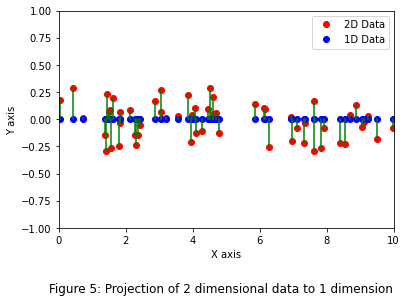

In [8]:
np.random.seed(0)
num_data = 100
y_vals = np.random.uniform(-0.3, 0.3, num_data) # generate random y coordinates
x_vals = np.random.uniform(-10, 10, num_data) # generate random x coordinates
plt.figure()
plt.plot(x_vals, y_vals, 'ro', label="2D Data") # plot 2D data
plt.plot(x_vals, np.zeros(num_data), 'bo', label="1D Data") # plot 1D data

for i in range(num_data): # plot the euclidean distance vectors
    plt.plot([x_vals[i], x_vals[i]], [0, y_vals[i]], color='g')
plt.axis([0,10,-1,1])
plt.xlabel("X axis")
plt.ylabel("Y axis")
plt.figtext(0.5, -0.1, "Figure 5: Projection of 2 dimensional data to 1 dimension", wrap=True, horizontalalignment='center', fontsize=12)
plt.legend()

## 5 Eigenvector Computation and Low-Rank Approximations
Up until now, we have learned that the basis of the prinicipal subspace are the eigenvectors corresponding to the largest eigenvalues of $S$ \[3]. 

$$
\begin{equation}
S = \frac{1}{N}\sum_{n=1}^N x_nx_n^\top = \frac{1}{N}XX^\top  \tag{30}
\end{equation}
$$
$$
\begin{equation}
X = [x_1,...,x_N]\in \mathbb{R}^{D\times N} \tag{31}
\end{equation}
$$

We wish to find the egienvectors of $S$ and may follow two approaches:

- eigendecomposition,
- single value decomposition (SVD) \[3].

We will take the SVD approach in the following sections.

The SVD of $X$ is given by
$$
\begin{equation}
X = U \sum V^\top, \tag{32}
\end{equation}
$$

where:

- $U \in \mathbb{R}^{D\times D}$ and $ V^\top \in \mathbb{R}^{N\times N}$ are orthogonal matrices,
- $\sum \in \mathbb{R}^{D\times N}$ is all zero matrix except for the singular values $\sigma_{ii} \geq 0$ \[3].



### 5.1 PCA Using Low-Rank Matrix Approximations
The Eckart-Young theorem allows a way to estimate a low-dimensional representation of data \[3].  

The best rank-M approximation of $X$ may be written as

$$
\begin{equation}
\tilde{X}_M := \text{argmin}_{rk(A) \leq M}\|X-A\|_2 \in \mathbb{R}^{D\times N} \tag{33}
\end{equation}
$$
where $\|.\|_2$ is the spectral norm \[3]. If we halt SVD the top-M singular value we obtain (34) \[3].
$$
\begin{equation}
\tilde{X_M} = U_M\sum_MV_M^\top \in \mathbb{R}^{D\times N} \tag{34}
\end{equation}
$$
Matrices $U_M := [u_1,...,u_M] \in \mathbb{R}^{D\times M}$ and $V_M := [v_1,...,v_M] \in \mathbb{R}^{N\times M}$ are orthogonal and the diagonal matrix $\sum_M \in \mathbb{R}^{M\times M}$ contains the largest singular values of $X$ \[3].


### 5.2 PCA in High Dimensions
PCA requires the computation of the $D\times D$ data covariance matrix.  The computation of eigenvectors and eigenvalues scales cubically in $D$ \[3]. Thus, it is highly desirable to apply numerical approximation in order to save computation time.

Assumining a centered dataset $x_1,...x_N \in \mathbb{R}^D$, the data covariance matrix $S$ is given
$$
\begin{equation}
S = \frac{1}{N}XX^\top \in \mathbb{R}^{D\times D}, \tag{35}
\end{equation}
$$
 where $X = [x_1,...x_N]$ is a $D\times N$ matrix with the data points as it's columns \[3].

We will now assume $N\gg D$ (much less data points than dimensionality of the data).

In the case where there are no duplicate data points, and the covariance matrix $S$ has rank N and thus $D-N+1$ eigenvalues that are 0 \[3].

In PCA, we found the eigenvector equation 
$$
\begin{equation}
Sb_m = \lambda_mb_m, m=1,...,.M, \tag{36}
\end{equation}
$$

Subbing (35) into (36) and multiplying $X^\top \in \mathbb{R}^{N\times D}$ from the left gives (37) \[3].
$$
\begin{equation}
\frac{1}{N}X^\top X X^\top b_m = \lambda_mX^\top b_m \longleftrightarrow \frac{1}{N}X^\top Xc_m = \lambda_mc_m \tag{37}
\end{equation}
$$

Multiplying (37) by $X$ shows the eigenvalue/eigenvector equation with $S$, thus, $Xc_m$ is an eigenvector of $S$.

$$
\begin{equation}
\frac{1}{N}XX^\top Xc_m = \lambda_mXc_m = SXc_m 
\tag{38}
\end{equation}
$$




 

## 6 The Steps for Applying PCA

1. Mean subtraction: So far, we have assumed centered data in our formulations.  As such, me need to center the data by computing the mean $\mu$ of the dataset and subtracting it from all the data points \[3]. This ensures that our data's mean is $0$.

2. Standardization: Divide each of the data points by the standard deviation $\sigma_d$ for each dimension $d = 1,...,D$. This removes any units from the data, and makes the variance equal to 1 in all axes \[3].

3. Eigendecomposition of the covariance matrix: 
Calculate the data covariance matrix along with it's eigenvalues and eigenvectors \[3].  The covariance matrix is symmetric and as such the sectral theorem allows us to compute an ONB of eigenvectors \[3].

4. Projection:
We project data points $x_* \in \mathbb{R}^D$ onto the principal subspace by standardizing $x_*$ using standard deviation $\sigma_d$ and $\mu_d$ of the training data in the $dth$ dimension \[3].

$$
\begin{equation}
x_*^{(d)} \leftarrow \frac{x_*^{(d)} - \mu_d}{\sigma_d}. d=1,..,D \tag{39}
\end{equation}
$$
Thus $x_*^{(d)}$ is the $dth$ component of $x_*$.  The projection is obtained with (40) and its coordinates are (41) \[3].
$$
\begin{equation}
\tilde{x_*} = BB^\top x_* \tag{40}
\end{equation}
$$
$$
\begin{equation}
z_* = B^\top x_*. \tag{41}
\end{equation}
$$
The coordinates are with respect to the basis of the principal subspace \[3].

$B$ is a matrix containing the eigenvectors associated with the largest eigenvalues of $S$ in it's columns \[3].  It is important to note that PCA returns the coordinates $z_*$ and not the projections \[3].

The projection obtained from (40) returns a projection in the context of the standardized dataset, and thus to obtain the projection in the original data space we can undo the standardization by (42) \[3].

$$
\begin{equation}
\tilde{x_*}^{(d)} \leftarrow \tilde{x_*}^{(d)} \sigma_d + \mu_d, d=1,...,D. \tag{42}
\end{equation}
$$

### Example 6.0.1 Applying PCA to the Iris Dataset

We are now ready to apply PCA to our iris dataset.  We will use ```sklearn.decomposition.PCA``` to do all the legwork.  I created three functions useful in visualizing PCA: 

1. ```standardize()```
2. ```pca()```
3. ```pcaplot()```

Refer to the doc strings for how to use these if you wish to take them!


In [9]:
def standardize(df):
    """
    Takes a dataframe, and gathers a standardized version of it.
    Arguments
        df : some pandas dataframe
        return : a standardized version  of the df
    """
    names = df.columns
    scaler = preprocessing.StandardScaler()
    std_df = scaler.fit_transform(df)
    std_df = pd.DataFrame(std_df, columns=names)
    return std_df

def pca(df):
    """
    Applies principal component analysis to a dataframe, returning it's 2 dimensional representation along with the inverse transformed dataframe.
    Arguments
        df : standardized df 
    Return: pandas dataframe for the PCA, the inverse transformed dataframe
    """
    pca = PCA(n_components=2)
    pcomps_arr = pca.fit_transform(df)
    pcomps_inv = pca.inverse_transform(pcomps_arr)

    pcomp_df = pd.DataFrame(data = pcomps_arr, columns = ['principal 1', 'principal 2'])
    pcomp_dfinv = pd.DataFrame(data = pcomps_inv, columns = df.columns)
    return pcomp_df, pcomp_dfinv



def pcaplot(pcomp_df, df, targets, targ_col, pt_size=10, l_size=10, colors=None, cap=""):
    """
    Plots a PCA array with colors for visualization
    Arguments 
        pcomp_df : principal component dataframe
        df : original data frame
        targ_col : the column in df with the target info,
        pt_size : the size of the data points
        colors (list, optional): specify the colors, or they will be randomly generated
        cap (str, optional): the caption for the figure
    """
    if colors is not None:
        if len(colors) != len(targets):
            raise ValueError("colors and targets must be the same length!")
    
    for i, t in enumerate(targets):
        color = colors[i] if colors is not None else np.random.rand(3,)
        indices = df[targ_col] == t

        plt.scatter(pcomp_df.loc[indices, 'principal 1'], 
                    pcomp_df.loc[indices, 'principal 2'], c =[color], s = pt_size)
        plt.xlabel("Principal compoent 1")
        plt.ylabel("Principal component 2")
    plt.legend(targets,prop={'size': l_size})
    plt.figtext(0.5, -0.1, cap, wrap=True, 
                horizontalalignment='center', fontsize=12)


def filter_badrows(df, badvals:list):
    """
    Arguments
        df : the dataframe
        filters : list of values in the df to drop
    """
    filt = {val : np.nan for val in badvals}
    filt_data = df.replace(filt).dropna().astype(float) 
    return filt_data

def printdf(df, title):
    """
    Print a df fully
    """
    print(f"--- --- {title} --- ---")
    with pd.option_context("display.max_rows", len(df), 'display.expand_frame_repr', False):
        print(df)
    print("--- --- --- --- --- ---")

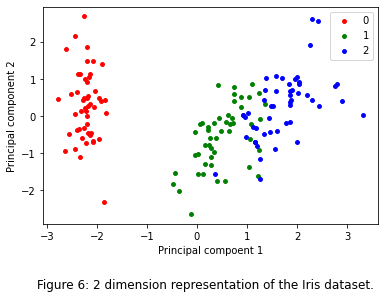

In [10]:
iris_pcompdf, iris_pcompinv = pca(iris_stdz)
caption="Figure 6: 2 dimension representation of the Iris dataset."
pcaplot(iris_pcompdf,iris_fulldf, [0,1,2], 'target', pt_size=15, colors=['r', 'g', 'b'], cap=caption)

## 7 The Latent Variable Perspective
A latent variable perspective is a probabilistic model which includes a continuous latent variable $z \in \mathbb{R}^M$ \[3]. Introducing $z$ enables us to model PCA probalistically, initially proposed by \[4] as probalistic PCA or PPCA.  Our previous formulations obtained by maximizing the variance or minimizing euclidean distance are actually the special case of the maximium likelihood estimation in a noise-free setting \[3].

### 7.1 Generative Process and Probablistic Model 

Assuming $z$ has a standard-normal prior $p(z) = \mathcal{N}(0,I)$ along with a linear relationship between latent variables and $x$ data 
$$
\begin{equation}
x = Bz + \mu + \epsilon \in \mathbb{R}^D, \tag{43}
\end{equation}
$$
where $\epsilon \sim \mathcal{N}(0, \sigma^2I)$ is the Gaussian observation noise while $B \in \mathbb{R}^{D\times M}$ and the mean $\mu \in \mathbb{R}^D$ describe the linear affine mapping from $z$ to $x$ \[3].

(41) presents the linkage from the latent to observed variable:
$$
\begin{equation}
p(x|z, B, \mu, \sigma^2) = \mathcal{N}(x|Bz + \mu, \sigma^2I). \tag{44}
\end{equation}
$$

PPCA can thus be modelled as a generative process:
$$
\begin{equation}
z_n \sim \mathcal{N}(z|0,I) \tag{45}
\end{equation}
$$
$$
\begin{equation}
x_n | z_n \sim \mathcal{N}(x|Bz_n + \mu, \sigma^2I) \tag{46}
\end{equation}
$$

Utilizing an ancestral sampling scheme, that is sampling $z_n$ from $p(z)$ enables the use of $z_n$ in (44) to produce $x_n \sim p(x|z_n, B, \mu, \sigma^2)$ \[3]. Thus, \[3] denotes the probalistic model as
$$
\begin{equation}
p(x,z|B,\mu,\sigma^2) = p(x|z, B, \mu, \sigma^2)p(z). \tag{47}
\end{equation}
$$

### 7.2 Likelihood and Joint Distribution
The likelihood of a probabilistic distribution is obtained by integrating out the latent variable $z$ such that 

$$
\begin{equation}
p(x|B, \mu,\sigma^2) = \int p(x|z, B, \mu, \sigma^2)p(z) dz = \int \mathcal{N}(x|Bz + \mu, \sigma^2I)\mathcal{N}(z|0, I)dz \tag{48}
\end{equation}
$$

Section 6.5 of \[3] tells us that the solutions to this integral have a mean defined in (49) and are Gaussian distributed.
$$
\begin{equation}
E_x[x] = E_z[Bz + \mu] + E_\epsilon[\epsilon] = \mu \tag{49}
\end{equation}
$$
The solution also has a covariance matrix defined as (50) \[3].
$$
\begin{equation}
\mathbb{V}[x] = \mathbb{V}_z[Bz + \mu] + \mathbb{V}_\epsilon [\epsilon] - \mathbb{V}_z[Bz] + \sigma^2I \\
              = B\mathbb{V}_z[z]B^\top + \sigma^2I = BB^\top + \sigma^2I \tag{50}
\end{equation}
$$

Section 6.5 in \[3] reminds us that the linear\affine transformation $x=Bz$ and $z$ itself are jointly Gaussian distributed.  We can thus determine the marginals: $p(z)=\mathcal{N}(z|0, I)$ and $p(x) = \mathcal{N}(x|\mu, BB^\top + \sigma^2I)$\[3].

The cross variance follows as 
$$
\begin{equation}
\text{Cov}[x,z] = \text{Cov}[Bz + \mu] = B\text{Cov}[z,z] = B. \tag{51}
\end{equation}
$$
Finally, we model the probabilistic model of PPCA as 
$$
\begin{equation}
p(x,z|B,\mu,\sigma^2) = \mathcal{N}\left(\begin{bmatrix}x\\z\end{bmatrix} \Big| \begin{bmatrix}\mu\\0\end{bmatrix}, \begin{bmatrix}BB^\top + \sigma^2I & B \\ B^\top & I \end{bmatrix}\right). \tag{52}
\end{equation}
$$

### Example 7.2.1 Undoing the PCA Transform

We can undo the PCA transform to observe how our data compares to the original.  My previously defined function ```pca()``` actually returns the inverse transformed data already.  I will use the reconstructed data to compare against the original observing the mean squared error of the reconstruction.  

In [11]:
rand_samples = [1,10,30] # indexes of the data to be samples for examination

for s in rand_samples:
    print(f"Data at index {s}\n")
    print(f"Original: \n")
    print(iris_stdz.loc[s])
    print(f"\nReconstructed: \n")
    print(iris_pcompinv.loc[s])
    print("--- -- --- -- ---\n")

printdf(iris_stdz.subtract(iris_pcompinv), "Difference Between the Standardized Features and Reconstructed Features")

Data at index 1

Original: 

sepal length   -1.143017
sepal width    -0.131979
petal length   -1.340227
petal width    -1.315444
Name: 1, dtype: float64

Reconstructed: 

sepal length   -1.338748
sepal width    -0.061923
petal length   -1.224328
petal width    -1.220572
Name: 1, dtype: float64
--- -- --- -- ---

Data at index 10

Original: 

sepal length   -0.537178
sepal width     1.479398
petal length   -1.283389
petal width    -1.315444
Name: 10, dtype: float64

Reconstructed: 

sepal length   -0.734883
sepal width     1.547125
petal length   -1.231793
petal width    -1.153788
Name: 10, dtype: float64
--- -- --- -- ---

Data at index 30

Original: 

sepal length   -1.264185
sepal width     0.098217
petal length   -1.226552
petal width    -1.315444
Name: 30, dtype: float64

Reconstructed: 

sepal length   -1.305567
sepal width     0.110596
petal length   -1.254512
petal width    -1.242637
Name: 30, dtype: float64
--- -- --- -- ---

--- --- Difference Between the Standardized Features

From visual inspection, we can see that there is some error in our estimation. We can quantify the error by obtaining the mean squared error between the dataframes.

In [12]:
from sklearn.metrics import mean_squared_error

iris_loss = mean_squared_error(iris_stdz, iris_pcompinv)
print(f"Mean squared error between the original and reconstructed data: {iris_loss}")

Mean squared error between the original and reconstructed data: 0.041867927999983595


Note how small the error is. We expect this as the maximum captured variance was achieved at approximately 2 eigenvalues, or prinicpal components.

### 7.3 Posterior Distribution

Our formulation of the joint Gaussian distribution from (52) enables us to determine the posterior distribution $p(z|x)$ through the rules of Gaussian condition \[3].

Using an observation $x$, we determine the posterior distribution of the latent variable as
$$
\begin{equation}
p(z|x) = \mathcal{N}(z|m,C) \tag{53}
\end{equation}
$$
where $m=B^\top(BB^\top + \sigma^2I)^{-1}(x-\mu)$ and $C = I-B^\top(BB^\top + \sigma^2I)^{-1}B$ \[3].

Posterior covariance has no dependency on $x$ \[3].  If we obtain a new observation $x_*$ we can apply (53) to get the posterior distribution of the latent variable $z_*$ \[3].  C is the covariance matrix, and a small determinant for $C$ lets us know that $z_*$ is relatively accurate \[3].  If there are large amounts of variance in our posterior distribution, an outlier may exist \[3].  By eploiting the generative underlying process of PPCA we can explore the posterior distribution on any $z_*$ by 

- Sampling $z_* \sim p(z|x_*)$
- Get the reconstructed vector $\tilde{x_*} \sim p(z|z_*, B, \mu, \sigma^2)$

This process of sampling many times allows us to hypothesize the data \[3].

# 8 - Other PCA Visualizations on Data
Our mathematical discussion of PCA is now complete.  I present two more examples of PCA applied to different datasets selected from \[5].

## 8.1 - Analysis on Heart Attack Victims
We will begin by loading some data from \[5] corresponding to heart attack victims.

The columns of the data are described in \[5] as:

1. survival -- the number of months patient survived (has survived, if patient is still alive). Because all the patients had their heart attacks at different times, it is possible that some patients have survived less than one year but they are still alive. Check the second variable to confirm this. Such patients cannot be used for the prediction task mentioned above. 
2. stillalive -- a binary variable. 0=dead at end of survival period, 1 means still alive 
3. ha-age -- age in years when heart attack occurred 
4. pe-eff -- binary. Pericardial effusion is fluid around the heart. 0=no fluid, 1=fluid 
5. fs -- a measure of contracility around the heart lower numbers are increasingly abnormal 
6. epss -- E-point septal separation, another measure of contractility. Larger numbers are increasingly abnormal. 
7. lvdd -- left ventricular end-diastolic dimension. This is a measure of the size of the heart at end-diastole. Large hearts tend to be sick hearts. 
8. wms -- a measure of how the segments of the left ventricle are moving 
9. wmi -- equals wall-motion-score divided by number of segments seen. Usually 12-13 segments are seen in an echocardiogram. Use this variable INSTEAD of the wall motion score. 
10. mult -- a derivate var which can be ignored 
11. name -- the name of the patient (I have replaced them with "name") 
12. group -- meaningless, ignore it 
13. alive-at-1 -- derived from the first two attributes. 0 means patient was either dead after 1 year or had been followed for less than 1 year. 1 means patient was alive at 1 year. 

--- --- Heart Attack Data Features Head --- ---
   survival  ha-age  pe-eff     fs    epss   lvdd   wms   wmi
0      11.0    71.0     0.0  0.260   9.000  4.600  14.0  1.00
1      19.0    72.0     0.0  0.380   6.000  4.100  14.0  1.70
2      16.0    55.0     0.0  0.260   4.000  3.420  14.0  1.00
3      57.0    60.0     0.0  0.253  12.062  4.603  16.0  1.45
4      19.0    57.0     0.0  0.160  22.000  5.750  18.0  2.25
--- --- --- --- --- ---


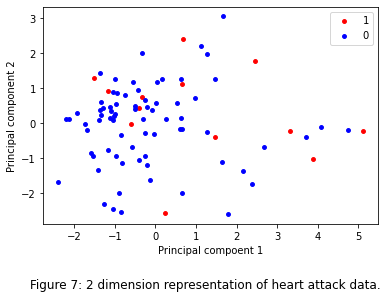

In [13]:
"""
Heart attack victim PCA analysis 
"""
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/echocardiogram/echocardiogram.data"
data = requests.get(url).text

cols = ["survival", "stillalive", "ha-age", "pe-eff", "fs", "epss", "lvdd", "wms", "wmi", "mult", "name",        "group", "alive-at", "null"]
drop_cols = ["mult", "name", "group", "alive-at", "null"]
feature_col = ["stillalive"]

df = pd.DataFrame([x.split(',') for x in data.split('\n')], columns=cols) # load dataframe
df_valid = df.drop(df.loc[(df["survival"] < "12") & (df["stillalive"] == "1")].index) # remove any invalid patients (see point 1 in the above attribute description)
df_valid.drop(columns=drop_cols, inplace=True) # drop any additional extraneous data not needed

filtered_df = filter_badrows(df_valid, ["?", "None"]) # filter out rows with None or ?, creating dataset with labels
feature_df = filtered_df.drop(columns=feature_col) # create dataset with only the feature for PCA

filtered_df.reset_index(inplace=True, drop=True)
feature_df.reset_index(inplace=True, drop=True)

printdf(feature_df.head(), "Heart Attack Data Features Head")
std_df = standardize(feature_df) # standardize
pcomp_df, pcomp_inv = pca(std_df) # apply PCA
caption="Figure 7: 2 dimension representation of heart attack data."
pcaplot(pcomp_df,filtered_df, [1, 0], 'stillalive', pt_size=15, colors=['r','b'], cap=caption) # plot


We do not see a clear separation in the heart attack victims for those who lived (1) versus those who died (0) for the dataset.

## 8.2 - Letter Recognition

Another data set for classification from \[5] is a dataset containing attributes about hand written capital letters in the english alphabet.

The columns of the dataset are presented below:

1. lettr - capital letter (26 values from A to Z) 
2. x-box - horizontal position of box (integer) 
3. y-box - vertical position of box (integer) 
4. width - width of box (integer) 
5. high - height of box (integer) 
6. onpix - total # on pixels (integer) 
7. x-bar - mean x of on pixels in box (integer) 
8. y-bar - mean y of on pixels in box (integer) 
9. x2bar - mean x variance (integer) 
10. y2bar - mean y variance (integer) 
11. xybar - mean x y correlation (integer) 
12. x2ybr - mean of x * x * y (integer) 
13. xy2br - mean of x * y * y (integer) 
14. x-ege - mean edge count left to right (integer) 
15. xegvy - correlation of x-ege with y (integer) 
16. y-ege - mean edge count bottom to top (integer) 
17. yegvx - correlation of y-ege with x (integer)

Note: the dataset is quite large, and as such the below cell should execute in around 10 seconds.


--- --- Letter Data With Labels Head --- ---
  lettr x-box y-box width high onpix x-bar y-bar x2bar y2bar xybar x2ybr xy2br x-ege xegvy y-ege yegvx
0     T     2     8     3    5     1     8    13     0     6     6    10     8     0     8     0     8
1     I     5    12     3    7     2    10     5     5     4    13     3     9     2     8     4    10
2     D     4    11     6    8     6    10     6     2     6    10     3     7     3     7     3     9
3     N     7    11     6    6     3     5     9     4     6     4     4    10     6    10     2     8
4     G     2     1     3    1     1     8     6     6     6     6     5     9     1     7     5    10
--- --- --- --- --- ---


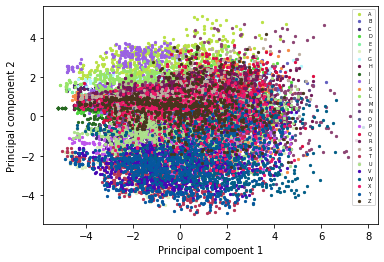

In [14]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data"
data = requests.get(url).text
cols = ["lettr", "x-box","y-box", "width", "high", "onpix", "x-bar", "y-bar", "x2bar", "y2bar", "xybar", "x2ybr", "xy2br", "x-ege", "xegvy",    "y-ege", "yegvx"]
df = pd.DataFrame([x.split(',') for x in data.split('\n')], columns=cols) # load dataframe
df.drop(index=len(df)-1, inplace=True)
feature_df = df.drop(columns=["lettr"])
printdf(df.head(), "Letter Data With Labels Head")

targets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
std_df = standardize(feature_df) # standardize
pcomp_df, pcomp_inv = pca(std_df) # apply pca
caption="Figure 8: 2 dimension representation of the letters dataset."
pcaplot(pcomp_df, df, targets, 'lettr', pt_size=5, l_size=5) # plot results

In this example, the clustering of the data is more clear.

# 9 Conclusion

In conclusion, dimensionality reduction is an incredibly useful tool in data analysis.  By reducing data to two dimensions, we can not only abstract a better understanding of the datas patterns, but also massively reduce storage size by removing redundant data.  I hope that this notebook was helpful in explaining the math behind PCA, and how to apply it using python.

## References

\[1]  K.   Pearson,   “On lines and planes of closest fit to systems of points in space,” The London, Edinburgh, and Dublin Philosophical Magazine and Journal of Science, vol. 2, no. 11,  pp. 559–572, 1901. [Online]. Available: https://doi.org/10.1080/14786440109462720.

\[2]  H.  Hotelling,  “Analysis  of  a  complex  of  statistical  variables into principal components.” Journal of Educational Psychology, vol. 24, no. 7, pp. 498–520, 1933.

\[3]  M. P. Deisenroth, A. A. Faisal, and C. S. Ong, Mathematics for Machine Learning. Cambridge University Press, 2020.

\[4]  M. E. Tipping and C. M. Bishop, “Probabilisticprincipal component analysis,” Journal of the Royal Statistical Society.  Series B (Statistical Methodology), vol. 61, no. 3, pp. 611–622, 1999. [Online]. Available: http://www.jstor.org/stable/268072650.

\[5] Dua and C. Graff, “UCI machine learning repository,” 2017. [Online]. Available: http://archive.ics.uci.edu/ml50.

